In [18]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from itertools import product

from scipy.stats import chi2_contingency
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter

# Input Parameter Settings
Users are required to define path to input dataset within the project directory
An output file will then be created in the same directory

In [19]:
# get root directory
ROOT = os.getcwd()

# setup parameters
params = {}
params['input data file'] = os.path.join(ROOT + '/irae_combined_cleaned.csv')

# Define Function For Displaying Formatted P-Value

In [20]:
def latex_p(p):
    if p < 0.001:
        output = str('(p<$\mathregular{10^{%1.0f}}$)' % (0.5 + np.log10(p)))
    elif p < 0.01:
        output = str('(p<0.01)')
    elif p < 0.05:
        output = str('(p<0.05)')
    else:
        output = str('(p=%0.2f)' % p)
    return output

# Import Dataset
Create target variables for survival analysis

In [21]:
# read data from input files
input_data = pd.read_csv(params['input data file'])

In [22]:
input_data.head()

,Sex,Race,Age_at_diagnosis,Histology,Stage,Immunotherapy_Class,TKI+,PD_L1_Range,Time_to_irae1,irAE_EarlyLate,...,ImClass_anti-pd-l1,ImClass_anti-pd-1,PD_L1_Range_>=50%,PD_L1_Range_1-49%,PD_L1_Range_Negative,PD_L1_Range_Positive,irAE+,irAE_early,irAE_late,irAE_category_IRAE
0,Female,NaN,65,adenocarcinoma,4.0,anti-pd-1,0,No Measurement of Negative,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
1,Male,White,85,adenocarcinoma,4.0,anti-pd-l1,0,No Measurement of Negative,1.0,Early irAE,...,1,0,0,0,0,0,1,1,0,1
2,Male,Asian,61,adenocarcinoma,4.0,anti-pd-1,0,>=50%,62.0,Early irAE,...,0,1,1,0,0,1,1,1,0,1
3,Female,Black or African American,66,other,4.0,anti-pd-l1,0,1-49%,NaN,NaN,...,1,0,0,1,0,1,0,0,0,0
4,Male,NaN,63,adenocarcinoma,4.0,anti-pd-1,0,>=50%,167.0,Late irAE,...,0,1,1,0,0,1,1,0,1,1


In [23]:
# convert days to months
input_data['os_months'] = round(input_data['os_days'] / 30.0)
input_data['pfs_months'] = round(input_data['pfs_days'] / 30.0)
input_data['pfs_months'] = input_data['pfs_months'].fillna(0)

# Chi-square Test of Independence Between Categorical Variables and Survival Outcome

In [24]:
# choose survival outcomes and categorical features
select_features = ['os_1yr_isDeceased', 'pfs_6months_isProgressed',
                   'Sex', 'Race', 'Histology', 'Stage', 'Smoker+', 'Prior_TKI+', 'Immunotherapy_Class',
                   'PD_L1_Range', 'irAE+', 'irAE_EarlyLate', 'irAE_category', 'Grade_of_irAE']

## split this list into two parts
cat_var1 = select_features
cat_var2 = select_features

## create all possible combinations between the above two variables list
cat_var_prod = list(product(cat_var1, cat_var2, repeat = 1))

In [25]:
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(chi2_contingency(pd.crosstab(input_data.loc[input_data['label']=='train', i[0]],\
                                                                   input_data.loc[input_data['label']=='train', i[1]]), lambda_="log-likelihood"))[1]))

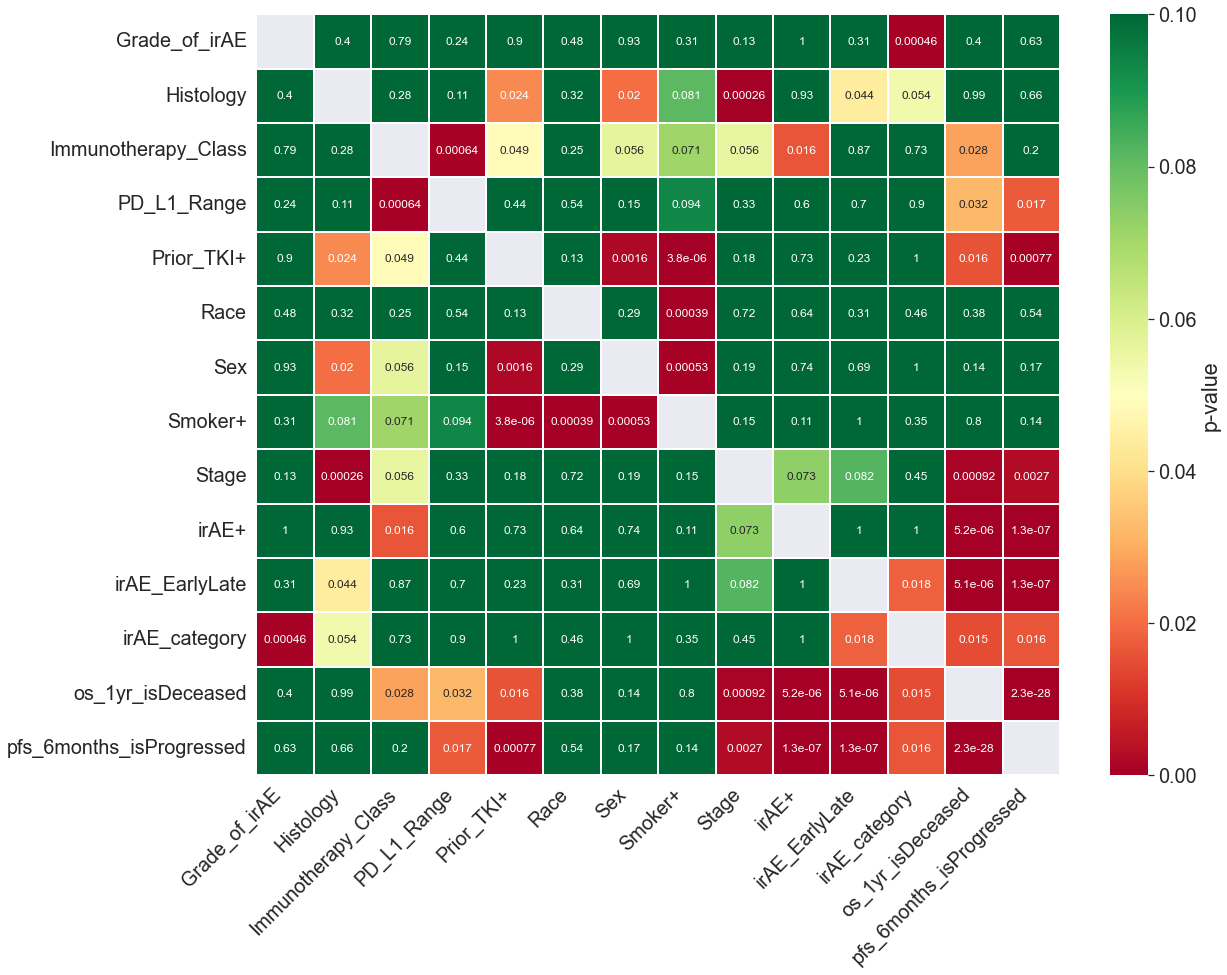

In [26]:
chi_test_output = pd.DataFrame(result, columns = ['Feature 1', 'Feature 2', 'coeff'])

# using pivot function to convert the above DataFrame into a crosstab
chi_test_output = chi_test_output.pivot(index='Feature 1', columns='Feature 2', values='coeff')

# display result
plt.figure(figsize=(18,14))
sns.set(font_scale=1.8)
sns.heatmap(chi_test_output,linewidths=.1,cmap="RdYlGn", vmin=0, vmax=0.1, annot=True, annot_kws={"size": 12}, cbar_kws={'label': 'p-value'})
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, horizontalalignment='right');